# Goodreads Reading List Recommender Project (Recommender)

In [1]:
# Import basic data libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import other functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Import helper functions from functions.py
import functions

In [2]:
# Use this cell to toggle between setting display.max_colwidth to None and resetting it

# Set max column width to None (no limit) so that I can see the whole text
# pd.set_option('display.max_colwidth', None)

# Reset the max column width so the pd.DataFrame is more compact
pd.reset_option('display.max_colwidth')

## Importing and Inspecting

In [3]:
# Read in the cleaned books table
books = pd.read_pickle('../Data/books.pkl')

# Look at the shape of the books table
print(books.shape)

# Look at the head of the books table
books.head(2)

(13525, 20)


,work_id,isbn,isbn13,original_title,author,original_publication_year,num_pages,description,image_url,reviews_count,text_reviews_count,5_star_ratings,4_star_ratings,3_star_ratings,2_star_ratings,1_star_ratings,ratings_count,avg_rating,avg_days_to_finish,description_clean
0,2919130,1416534601,9781416534600,Nocturnes,John Connolly,2004.0,NaN,NaN,https://s.gr-assets.com/assets/nophoto/book/11...,8820,338,1118,1601,1029,190,58,3996,3.9,18.0,
1,52087333,NaN,NaN,Draw Play,Tia Lewis,2016.0,NaN,Jake:\nI can't believe my coach assigned me a ...,https://s.gr-assets.com/assets/nophoto/book/11...,2482,204,204,353,274,77,29,937,3.7,4.0,jakei not believe coach assign tutor m field s...


In [4]:
# Look at the head of the engineered genres table
genres = pd.read_pickle('../Data/genres.pkl').set_index('work_id')

# Extract the work_id column order for later use
work_id = pd.Series(genres.index)

# Look at the shape of the genres table
print(genres.shape)

# Look at the head of the books table
genres.head(2)

(13525, 16)


,biography,children,comics,crime,fantasy,fiction,graphic,historical fiction,history,mystery,non-fiction,paranormal,poetry,romance,thriller,young-adult
work_id,,,,,,,,,,,,,,,,
104,1,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0
114,1,0,0,0,1,1,0,1,1,0,0,1,0,1,0,0


In [5]:
# Read in the similar_books table
similar_books = pd.read_pickle('../Data/similar_books.pkl')

# Look at the shape of the books table
print(similar_books.shape)

# Look at the head of the books table
similar_books.head(2)

(13525, 13525)


,104,114,115,423,434,505,696,797,817,860,...,56825332,56847346,56947505,57104739,57400201,57407230,57414860,57438069,57646853,57717521
104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Read in the reviews table
reviews = pd.read_pickle('../Data/reviews.pkl')

# Look at the shape of the reviews table
print(reviews.shape)

# Look at the head of the reviews table
reviews.head(2)

(1143887, 13)


,review_id,user_id,work_id,started_at,read_at,date_added,rating,review_text,n_votes,n_comments,days_to_finish,spoiler_text,review_text_sf
0,fa7a00c01296e3b2b2e857d79c51ea77,3693bb4f1062b659a354848cf11ca313,6128277,NaT,NaT,2013-12-21,5.0,Fire is half-human and half monster. Monsters ...,0,0,NaT,NaN,Fire is half-human and half monster. Monsters ...
1,de0f7c8d15e247443e51969becf2878e,3693bb4f1062b659a354848cf11ca313,3270810,NaT,NaT,2013-12-21,5.0,Katsa is a graceling - blessed with an ability...,0,0,NaT,NaN,Katsa is a graceling - blessed with an ability...


## Recommenders

### Content-Based Filtering

#### Preprocess Data

From the EDA section, it was found that original_publication_year and num_pages have extreme outliers. Therefore, I will clip them before scaling to ensure accurate and balanced recommendations.

In [7]:
# Check the percentiles for the original_publication_year column since there are outliers
functions.get_percentiles(books, 'original_publication_year')

original_publication_year - 0.01 percentile: 1884.06
original_publication_year - 0.05 percentile: 1967.0
original_publication_year - 0.25 percentile: 2006.0
original_publication_year - 0.5 percentile: 2011.0
original_publication_year - 0.75 percentile: 2014.0
original_publication_year - 0.95 percentile: 2016.0
original_publication_year - 0.99 percentile: 2017.0


------------------------------------------------------------------------------------------------------------------------------

In [8]:
# Check the percentiles for the num_pages column since there are outliers
functions.get_percentiles(books, 'num_pages')

num_pages - 0.01 percentile: 39.94
num_pages - 0.05 percentile: 128.0
num_pages - 0.25 percentile: 260.0
num_pages - 0.5 percentile: 334.0
num_pages - 0.75 percentile: 391.0
num_pages - 0.95 percentile: 551.2999999999993
num_pages - 0.99 percentile: 792.239999999998


In [9]:
# Create clipped columns of original_publication_year and num_pages to reduce the influence of outliers
books['opy_clipped'] = books['original_publication_year'].clip(lower=books['original_publication_year'].quantile(0.05))
books['np_clipped'] = books['num_pages'].clip(upper=books['num_pages'].quantile(0.99).round())

# Fill the  missing values of the clipped columns with their respective medians of since only <1% and 5% is missing
books['np_clipped'] = books['np_clipped'].fillna(books['np_clipped'].median())
books['opy_clipped'] = books['opy_clipped'].fillna(books['opy_clipped'].median())

In [10]:
# Put the clipped original_publication_year and num_pages columns on a 0-1 scale so it matches the dummy variable scale
mms = MinMaxScaler()
books_scaled = mms.fit_transform(books[['opy_clipped', 'np_clipped']])
books = pd.concat([books, pd.DataFrame(books_scaled, columns=['opy_scaled', 'np_scaled'])], axis=1)

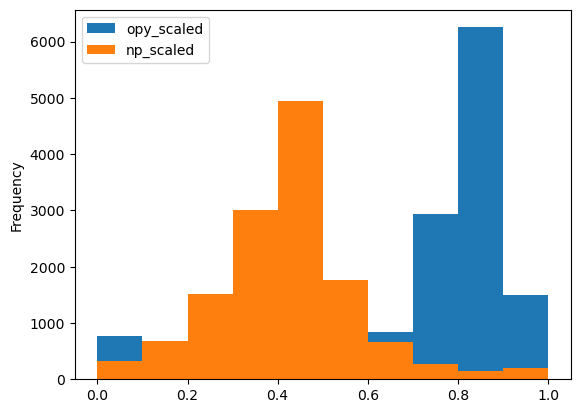

In [11]:
# Look at the distribution of the scaled and clipped columns
books[['opy_scaled', 'np_scaled']].plot.hist();

In [12]:
# Create a df with opy and np as features in the same order as the genres df
opy_np = books[['work_id', 'opy_scaled', 'np_scaled']].set_index('work_id').sort_index()

------------------------------------------------------------------------------------------------------------------------------

In [13]:
# Find out the number of different authors there are in the books table
print(f"Number of Authors: {books['author'].nunique()}")

# Find out how many authors have more than one book in the books table
print(f"Number of Multiple Publishing Authors: {sum(books['author'].value_counts() > 1)}")

# Find out how many books there are in the books table
print(f'Number of Books: {books.shape[0]}')

Number of Authors: 5554
Number of Multiple Publishing Authors: 2214
Number of Books: 13525


There are too many authors to create dummies that can be inputted into the cosine_similarity function. Therefore, instead, I plan to increase the cosine_similarity of two books by x (to be decided later) if they are written by the same author.

------------------------------------------------------------------------------------------------------------------------------

In [14]:
tv = TfidfVectorizer(stop_words='english', min_df=0.15)
tfidf = tv.fit_transform(books['description_clean'])
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=tv.get_feature_names_out(), index=books['work_id'])

# Sort in the same order as genres table
tfidf_df = tfidf_df.sort_index()

tv.get_feature_names_out()

array(['come', 'family', 'friend', 'good', 'know', 'leave', 'life',
       'like', 'live', 'love', 'man', 'new', 'secret', 'story', 'thing',
       'time', 'want', 'way', 'world', 'year', 'young'], dtype=object)

------------------------------------------------------------------------------------------------------------------------------

In [15]:
# Weight the types of features
genres_weighted = genres * 0.65
tfidf_df_weighted = tfidf_df * 0.3
opy_np_weighted =  opy_np * 0.05

# Join each dataframe to create a matrix that will be inputted into a cosine_similarity function
model_data = pd.concat([genres_weighted, tfidf_df_weighted, opy_np_weighted], axis=1)

# Seperate the columns by category and assign the appropriate variable
genre_cols = ['biography', 'children', 'comics', 'crime', 'fantasy', 'fiction', 'graphic', 'historical fiction', 'history', 'mystery', 'non-fiction', 'paranormal', 'poetry', 'romance', 'thriller', 'young-adult']
year_col = ['opy_scaled']
num_pages_col = ['np_scaled']
tfidf_cols = ['come', 'family', 'friend', 'good', 'know', 'leave', 'life', 'like', 'live', 'love', 'man', 'new', 'secret', 'story', 'thing', 'time', 'want', 'way', 'world', 'year', 'young']

# Select columns
X = model_data[(
    genre_cols +
    year_col +
    # num_pages_col + 
    tfidf_cols
)]

In [16]:
# Create a cosine similarity matrix that will be used for the similar books recommender 
cos_sim_matrix = cosine_similarity(X)

------------------------------------------------------------------------------------------------------------------------------

In [17]:
# Add a booster if the books are similar
similar_books_booster = 0.25
cos_sim_matrix = cos_sim_matrix + np.array(similar_books.replace(1, similar_books_booster))

------------------------------------------------------------------------------------------------------------------------------

In [18]:
# Get the authors series (the same order as the model_data work_id index order)
authors = pd.DataFrame(work_id).merge(books[['work_id', 'author']])
authors.index = authors['work_id']
authors = authors.drop('work_id', axis=1)

# Compare all pairs using broadcasting (outer comparison)
same_author_matrix = (authors['author'].values[:, None] == authors['author'].values[None, :]).astype(int)
same_author = pd.DataFrame(same_author_matrix)

# Add a booster if the books are written by the same author
same_author_booster = 0.1
cos_sim_matrix = cos_sim_matrix + np.array(same_author.replace(1, same_author_booster))

------------------------------------------------------------------------------------------------------------------------------

In [19]:
# Turn the cosine_similarity matrix into a pd.DataFrame
cos_sim = pd.DataFrame(cos_sim_matrix, columns=work_id, index=work_id)
cos_sim.columns.name = None
cos_sim.index.name = None

In [20]:
# Export the cos_sim pd.DataFrame
cos_sim.to_pickle('../Data/books_similarity_scores.pkl')

------------------------------------------------------------------------------------------------------------------------------

#### Build Engine

In [21]:
def recommendations(books_list, num_rec=5):
    # Get the work_ids of the books in the books_list
    work_ids = np.array(books[books['original_title'].isin(books_list)]['work_id'].to_list())

    # Get the max (changed from average) similarity_scores of each book compared to the books in book_list
    sim_scores = pd.DataFrame(cos_sim.loc[:, work_ids].max(axis=1), columns=['mean_sim_score'])

    # Get all the information for each book and sort by mean_sim_score
    recommendations = (sim_scores.reset_index()
                                 .merge(books, left_on='index', right_on='work_id')
                                 .sort_values(by='mean_sim_score', ascending=False)
                      )

    # Remove books from books_list from recommendations and return num_rec rows
    recommendations = recommendations[~recommendations['work_id'].isin(work_ids)].iloc[:num_rec, 1:-5]
        
    return recommendations

##### Testing

In [22]:
# Initialise a list of my favourite books for quick testing
fav_books = [
    'The Silence of the Lambs', 
    'Anna Karenina', 
    'Idiot', 
    'The Catcher in the Rye', 
    'Nineteen Eighty-Four',
    'Lord of the Flies',
    'Animal Farm: A Fairy Story',
    'The Hunger Games'
]

recommendations(fav_books)

,mean_sim_score,work_id,isbn,isbn13,original_title,author,original_publication_year,num_pages,description,image_url,reviews_count,text_reviews_count,5_star_ratings,4_star_ratings,3_star_ratings,2_star_ratings,1_star_ratings,ratings_count,avg_rating,avg_days_to_finish
1339,1.224385,881425,0446677388,9780446677387,Kiss the Girls,James Patterson,1995.0,458.0,"In Los Angeles, a reporter investigating a ser...",https://s.gr-assets.com/assets/nophoto/book/11...,365582,2874,101039,96956,58658,14615,10547,281815,3.9,5.0
5235,1.083028,8812783,0439023513,9780439023511,Mockingjay,Suzanne Collins,2010.0,392.0,My name is Katniss Everdeen.\nWhy am I not dea...,https://images.gr-assets.com/books/1358275419m...,2397181,96736,749202,627098,378562,112136,30653,1897651,4.0,23.0
4338,1.074074,6171458,0439023491,9780439023498,Catching Fire,Suzanne Collins,2009.0,391.0,Sparks are igniting.\nFlames are spreading.\nA...,https://images.gr-assets.com/books/1358273780m...,2505702,89071,992769,696715,265971,48866,10703,2015024,4.3,23.0
5522,1.074074,11349083,0545265355,9780545265355,The Hunger Games Box Set,Suzanne Collins,2010.0,1155.0,"The extraordinary, ground breaking New York Ti...",https://images.gr-assets.com/books/1360094673m...,209265,6494,101137,43695,13685,2569,1035,162121,4.5,10.0
4137,1.067799,4912783,0192833987,9780192833983,Voina i mir',Leo Tolstoy,1868.0,1392.0,Tolstoy's epic masterpiece intertwines the liv...,https://images.gr-assets.com/books/1413215930m...,526253,8324,89250,61839,32645,9945,5084,198763,4.1,106.0


### Collaberative Filtering

In [23]:
# See how many unique users there are and how many books have been reviewed
print(f"Number of unique users: {reviews['user_id'].nunique()}")
print(f"Number of books reviewed: {reviews['work_id'].nunique()}")

Number of unique users: 18800
Number of books reviewed: 13525


In [24]:
# Drop the first review of the users who reviewed the same book twice (investigated in the DataCleaning section)
reviews_unique = (reviews.sort_values(by='date_added')
                         [~reviews.sort_values(by='date_added').duplicated(subset=['user_id', 'work_id'], keep='last')]
                         .sort_index()
                 )

In [25]:
# Create a user-item matrix that has user_id as index, work_id as columns, and rating as values
user_item = reviews_unique.pivot(index='user_id', columns='work_id', values='rating')

## Feature Engineering (Web App)

Add features that will act as flags in the web app

Created:
- Classics
- Hidden Gems

Other Possibilities:
- Short Read (low num_pages)
- Door Stopper (High num_pages)

5_star_ratings_percent - 0.01 percentile: 0.11312711314794567
5_star_ratings_percent - 0.05 percentile: 0.16654263565891472
5_star_ratings_percent - 0.25 percentile: 0.2540572440247861
5_star_ratings_percent - 0.5 percentile: 0.3238382099827883
5_star_ratings_percent - 0.75 percentile: 0.4061574896388396
5_star_ratings_percent - 0.95 percentile: 0.5301058637217008
5_star_ratings_percent - 0.99 percentile: 0.6277055193965076


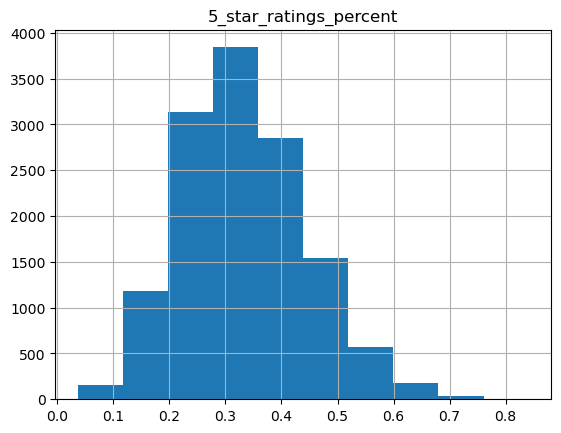

In [26]:
# Create a column that has the percentage of 5 star ratings for that book
books['5_star_ratings_percent'] = books['5_star_ratings'] / books['ratings_count']

# Inspect the column by looking at the key percentiles and histogram
functions.get_percentiles(books, '5_star_ratings_percent')
books.hist('5_star_ratings_percent');

In [27]:
# Set the classic tag requirment thresholds based on the inspected percentiles (checked year percentiles earlier)
classic_ratings_threshold = books['5_star_ratings_percent'].quantile(0.75)
classic_year_threshold = books['original_publication_year'].quantile(0.25)

# Save the classic tag logic in a variable for minipulation (summing and filtering)
mask = ((books['5_star_ratings_percent'] >= classic_ratings_threshold) & 
        (books['original_publication_year'] <= classic_year_threshold))

# Get the amount of books that are considered classics and the percentage of books considered classics
classics_amount = sum(mask)
classics_percent = round((classics_amount / len(books)) * 100, 2)
print(f'The amount of books that will be tagged as classics: {classics_amount}, which is {classics_percent}% of books.')

# Add a classics dummy variable to the books table
books['classics'] = np.where(mask, 1, 0)

The amount of books that will be tagged as classics: 882, which is 6.52% of books.


------------------------------------------------------------------------------------------------------------------------------

total_reviews_ratings - 0.01 percentile: 1266.24
total_reviews_ratings - 0.05 percentile: 2879.2
total_reviews_ratings - 0.25 percentile: 9729.0
total_reviews_ratings - 0.5 percentile: 24286.0
total_reviews_ratings - 0.75 percentile: 65674.0
total_reviews_ratings - 0.95 percentile: 352087.1999999999
total_reviews_ratings - 0.99 percentile: 1307669.3200000003


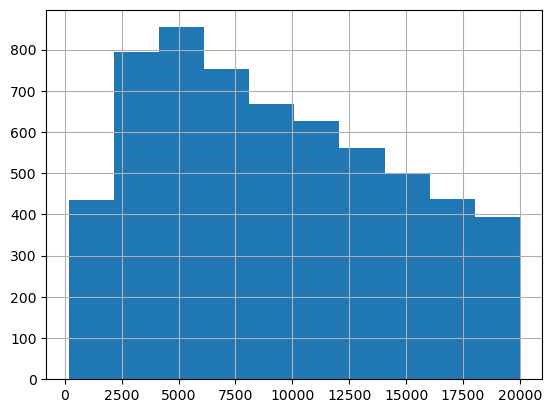

In [28]:
# Add a column that has the total reviews and ratings
books['total_reviews_ratings'] = books['reviews_count'] + books['ratings_count']

# Inspect the column by looking at the key percentiles and histogram
functions.get_percentiles(books, 'total_reviews_ratings')
books[books['total_reviews_ratings'] < 20000]['total_reviews_ratings'].hist();

In [29]:
# Set the hidden_gem tag requirment thresholds based on the inspected percentiles
gem_ratings_threshold = books['5_star_ratings_percent'].quantile(0.70)
gem_interaction_threshold = books['total_reviews_ratings'].quantile(0.25)

# Save the hidden_gem tag logic in a variable for minipulation (summing and filtering)
mask = ((books['5_star_ratings_percent'] >= gem_ratings_threshold) & 
        (books['total_reviews_ratings'] <= gem_interaction_threshold))

# Get the amount of books that are considered hidden gems and the percentage of books considered hidden gems
gem_amount = sum(mask)
gem_percent = round((gem_amount / len(books)) * 100, 2)
print(f'The amount of books that will be tagged as a hidden gem: {gem_amount}, which is {gem_percent}% of books.')

# Add a hidden_gem dummy variable to the books table
books['hidden_gem'] = np.where(mask, 1, 0)

The amount of books that will be tagged as a hidden gem: 617, which is 4.56% of books.


------------------------------------------------------------------------------------------------------------------------------

In [30]:
# Make sure there are no books that are simultaneously a classic and hidden gem
classic_gem = books[['classics', 'hidden_gem']].sum(axis=1) == 2
print(f'The amount of books that will are tagged as a hidden gem and classic: {sum(classic_gem)}')

# Prioritise classic over hidden gem. Therefore, remove hidden_gem flag from books that are both (can change this)
books['hidden_gem'] = np.where(classic_gem, 0, books['hidden_gem'])

The amount of books that will are tagged as a hidden gem and classic: 41
